---

### **Retrieve and Generate (RAG)**

Until now, we’ve been querying LLMs hosted on AWS Bedrock purely based on the model’s pretraining, which relies on large-scale internet data. While powerful, these models are not well-suited for answering questions about internal or domain-specific resources. In such cases, they often produce inaccurate or "hallucinated" responses, as they generate answers based solely on statistical probability rather than grounded knowledge.

To address this limitation, we use a technique called **Retrieval-Augmented Generation (RAG)**.

---

### **What is RAG?**

RAG enhances LLM performance by augmenting model inputs with relevant data retrieved from a custom knowledge base. Here's how it works:

1. **Data Preparation**: Internal documents or resources are parsed and converted into **embedding vectors**, which are then stored in a **vector database**.
2. **Query Handling**: When a user asks a question, the query is also converted into an embedding. A similarity search (commonly cosine similarity) is performed against the stored vectors to find the most relevant content.
3. **Response Generation**: The matched content is then transformed back into text and included in the prompt sent to the LLM. This gives the model context-specific knowledge to generate accurate, grounded responses.

Thanks to RAG, the model can now respond based on both its pre-trained knowledge and your internal data.

---

### **Two Key Phases of RAG**

1. **Indexing** *(Offline Process)*

   * Parse internal documents
   * Generate embeddings
   * Store embeddings in a vector store

2. **Retrieval and Generation** *(Runtime)*

   * Convert user query into an embedding
   * Find the closest matches in the vector store
   * Retrieve and format the matched content
   * Combine it with the user’s query and send it to the LLM

---

We’ll explore the implementation of RAG in more detail in the next sections.

In [1]:
!pip install langchain-text-splitters langchain-community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [langchain-community]ngchain-community]


In [2]:
!pip install -qU "langchain[aws]"

In [3]:
from langchain.chat_models import init_chat_model
model  = init_chat_model("anthropic.claude-3-5-sonnet-20240620-v1:0", model_provider="bedrock_converse")



---

### **Indexing**

To begin the indexing process, we use **document loaders** to load content from various sources. LangChain provides support for multiple data types, including:

* Web pages
* PDF files
* Plain text documents
* and more

These loaders help standardize and prepare the data for further processing and embedding.

📖 **Reference:**
[LangChain Document Loaders](https://python.langchain.com/docs/concepts/document_loaders/)

---



In [4]:
%pip install -qU pypdf

Note: you may need to restart the kernel to use updated packages.


In [6]:
from langchain_community.document_loaders import PyPDFLoader
# Filter to fetch the only required content from the document
# In this case only html tags with below values are only loaded
# bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-content", "post-header"))
# loader = WebBaseLoader(
#   web_paths = ("https://lilianweng.github.io/posts/2023-06-23-agent/"),
#   bs_kwargs={"parse_only": bs4_strainer},
# )
# docs = loader.load()

filePath = "<sample pdf file>"
loader = PyPDFLoader(filePath)
pages = []
async for page in loader.alazy_load():
  pages.append(page)


print(f"{pages[0].metadata}\n")
print(len(pages[0].page_content))

{'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-05-30T10:02:58-04:00', 'author': 'Resendiz, Elvia', 'moddate': '2025-05-30T10:02:58-04:00', 'source': './EVL.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}

840


In [7]:
from langchain_aws import BedrockEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")
vector_store = InMemoryVectorStore.from_documents(pages, embeddings)


In [8]:

"""
Sample code to search the vector store

docs = vector_store.similarity_search("<query>", k=2)
for doc in docs:
  print(f"Metadata: {doc.metadata["page"]}")
  print(f"Content: {doc.page_content}\n")

"""

'\nSample code to search the vector store\n\ndocs = vector_store.similarity_search("<query>", k=2)\nfor doc in docs:\n  print(f"Metadata: {doc.metadata["page"]}")\n  print(f"Content: {doc.page_content}\n")\n\n'



---

Now that our vector store is loaded with documents, it’s time to add the **Retrieve** and **Generate** nodes to the graph. This process is similar to setting up a chatbot.

**Steps:**

* Create nodes for **Retrieve** and **Generate**.

* Connect edges between **Start → Retrieve** and **Retrieve → Generate**.

* The **Retrieve** node performs a search on the vector store using the user’s question.

* The **Generate** node formats the prompt by combining the user’s question with the retrieved context, then invokes the model with this prompt to produce the response.

---






---

Let’s begin by designing the prompt template. We can create a custom prompt using LangChain’s prompt template library. For this example, we’ll use a RAG-specific template that has been shared on the LangChain Hub.

---


In [9]:

from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
  {"context": "(context goes here)", "question": "Question goes here"}
).to_messages()


/opt/miniconda3/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
from langchain_core.prompts import ChatPromptTemplate
example_messages = [
  { "role": "assistant", "content": "You are an AI assistant that helps users find information in a document. You are given a context and a question. Your task is to provide a concise answer based on the context." },
  { "role": "user", "content": "For the following question: {question}, give me the consice answer from this content: {content}" }
]
prompt_template = ChatPromptTemplate.from_messages(example_messages)
prompt_template


ChatPromptTemplate(input_variables=['content', 'question'], input_types={}, partial_variables={}, messages=[AIMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an AI assistant that helps users find information in a document. You are given a context and a question. Your task is to provide a concise answer based on the context.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['content', 'question'], input_types={}, partial_variables={}, template='For the following question: {question}, give me the consice answer from this content: {content}'), additional_kwargs={})])

In [11]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# defining the state for the rag, keeping track of the question, context, and answer
class State(TypedDict):
    question: str
    content: List[Document]
    answer: str

creating retreive and generate graph nodes

In [12]:
def retreive(state: State):
  retrieved_docs = vector_store.similarity_search(state["question"], k=2)
  return { "content": retrieved_docs }

def generate(state: State):
  content = "\n\n".join(doc.page_content for doc in state["content"])
  prompt = prompt_template.invoke({"question": state["question"], "content": content})
  responses = model.invoke(prompt)
  return { "answer": responses.content }

In [13]:
from langgraph.graph import START, StateGraph
graph_builder = StateGraph(State).add_sequence([ retreive, generate ])
graph_builder.add_edge(START, "retreive")
graph = graph_builder.compile()

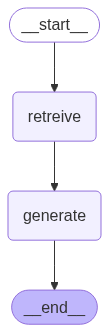

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
import pprint
result = graph.invoke({"question": "What is the position of the Dinesh Reddy Allam im purpose financial?"})
# pprint.pprint(f'Content: {result["content"]}\n\n')
pprint.pprint(f'Answer: {result["answer"]}\n\n')

('Answer: Based on the given content, the position of Dinesh Reddy Allam at '
 'Purpose Financial is Sr. Software Engineer.\n'
 '\n')




---

### Further Improvements / Use Cases: Enhancing Query Analysis

At a high level, we can introduce an additional step called **query analysis**. In this step, we analyze the user’s query using a model designed to produce structured output. Based on this structured output, we can perform a more targeted search in the vector store to retrieve more relevant documents.

**Example:**
When indexing documents into the vector store, we can enrich their metadata—for instance, by adding sentiment labels (positive, negative) during the data preparation phase. Then, as part of the initial stage in the processing graph, we can analyze the query’s sentiment using a structured-output model. This sentiment information is passed to the retrieve node, allowing it to refine the similarity search by also filtering based on the sentiment metadata.

The retrieved documents, now more closely aligned with the query’s intent, are then passed to the generate node for a more accurate and precise response.

---

**This query analysis step significantly improves the relevance of documents retrieved from the vector store.**

---


Here’s a simple example in Python using **LangChain** and **Pydantic** to create a query analysis model that outputs structured data (like sentiment), which can then be used to guide retrieval from a vector store.

---

### Sample Code: Query Analysis Model with Structured Output

```python
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate
from langchain.schema import BaseOutputParser
from pydantic import BaseModel, Field
from typing import Literal
import json

# 1. Define a Pydantic model for the structured output
class QueryAnalysisResult(BaseModel):
    sentiment: Literal["positive", "neutral", "negative"] = Field(..., description="Sentiment of the query")
    intent: str = Field(..., description="User intent extracted from query")

# 2. Create an output parser to parse the JSON response into the Pydantic model
class QueryAnalysisOutputParser(BaseOutputParser):
    def parse(self, text: str) -> QueryAnalysisResult:
        data = json.loads(text)
        return QueryAnalysisResult(**data)

# 3. Define the prompt template to instruct the LLM to output structured JSON
prompt_template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(
        "Analyze the user's query and provide the sentiment (positive, neutral, negative) and user intent in JSON format."
    ),
    HumanMessagePromptTemplate.from_template("{query}")
])

# 4. Initialize the chat model (using OpenAI GPT for example)
chat_model = ChatOpenAI(temperature=0)

# 5. Define a function to perform query analysis
def analyze_query(query: str) -> QueryAnalysisResult:
    # Format the prompt with the user query
    messages = prompt_template.format_messages(query=query)
    # Get the LLM response
    response = chat_model(messages)
    # Parse the JSON output into the structured model
    parsed_output = QueryAnalysisOutputParser().parse(response.content)
    return parsed_output

# Example usage
if __name__ == "__main__":
    user_query = "I am unhappy with the recent service update."
    analysis = analyze_query(user_query)
    print(f"Sentiment: {analysis.sentiment}")
    print(f"Intent: {analysis.intent}")
```

---

### Explanation:

* **Step 1:** Defines a Pydantic model `QueryAnalysisResult` with fields for sentiment and intent.
* **Step 2:** Implements a custom parser that converts the model’s JSON output into the Pydantic model.
* **Step 3:** Creates a prompt template that instructs the LLM to respond with a JSON containing sentiment and intent.
* **Step 4:** Sets up a chat model (you can replace this with any supported LLM).
* **Step 5:** Runs the query through the model and parses the structured output.

---

You can then use the sentiment and intent fields in your retrieval node to filter or enhance the vector store search.


